In [1]:
!pip install kaggle
!mkdir ~/.kaggle
from google.colab import files
files.upload()  # upload your kaggle.json here
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d olistbr/brazilian-ecommerce -p data --unzip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.43GB/s]


In [2]:
import pandas as pd
import os

files = os.listdir("data")
files


['olist_orders_dataset.csv',
 'olist_customers_dataset.csv',
 'olist_order_payments_dataset.csv',
 'product_category_name_translation.csv',
 'olist_sellers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv']

In [3]:
import pandas as pd
import os

path = "data"

orders = pd.read_csv(f"{path}/olist_orders_dataset.csv")
customers = pd.read_csv(f"{path}/olist_customers_dataset.csv")
reviews = pd.read_csv(f"{path}/olist_order_reviews_dataset.csv")
items = pd.read_csv(f"{path}/olist_order_items_dataset.csv")
payments = pd.read_csv(f"{path}/olist_order_payments_dataset.csv")
products = pd.read_csv(f"{path}/olist_products_dataset.csv")
sellers = pd.read_csv(f"{path}/olist_sellers_dataset.csv")


In [4]:
orders.head(), customers.head(), reviews.head()


(                           order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp    order_approved_at  \
 0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-07-26 14:31:00 

In [5]:
reviews["target"] = (reviews["review_score"] <= 3).astype(int)
reviews["target"].value_counts(normalize=True)


,proportion
target,
0,0.77068
1,0.22932


In [6]:
orders["customer_id"].nunique(), customers["customer_id"].nunique()
reviews["order_id"].nunique(), orders["order_id"].nunique()


(98673, 99441)

In [7]:
orders = orders[orders["order_status"] != "canceled"]


In [8]:
# Merge orders + customers
df = orders.merge(customers, on="customer_id", how="left")

# Add reviews
df = df.merge(reviews[["order_id", "target"]], on="order_id", how="inner")

# Add payments
df = df.merge(payments.groupby("order_id")
              .agg({"payment_sequential":"max",
                    "payment_type":"first",
                    "payment_installments":"max",
                    "payment_value":"sum"})
              .reset_index(),
              on="order_id", how="left")

# Add items (total price, freight, item count)
items_agg = items.groupby("order_id").agg({
    "price":"sum",
    "freight_value":"sum",
    "order_item_id":"count"
}).rename(columns={"order_item_id":"num_items"}).reset_index()

df = df.merge(items_agg, on="order_id", how="left")


In [9]:
date_cols = [c for c in df.columns if "date" in c or "timestamp" in c]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])


In [10]:
df = df.dropna(subset=["target"])


In [11]:
df.head()
df.shape
df["target"].value_counts(normalize=True)


,proportion
target,
0,0.774476
1,0.225524


In [12]:
# Delivery time (days)
df["delivery_time"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days

# Estimated delivery time
df["estimated_delivery_time"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.days

# Delay (delivery - estimate)
df["delay"] = df["delivery_time"] - df["estimated_delivery_time"]

# Late delivery flag
df["late_delivery"] = (df["delay"] > 0).astype(int)


In [13]:
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_day"] = df["order_purchase_timestamp"].dt.day
df["purchase_weekday"] = df["order_purchase_timestamp"].dt.weekday


In [14]:
df["customer_state"] = df["customer_state"].astype("category")
df["customer_city"] = df["customer_city"].astype("category")


In [15]:
df = df.dropna(subset=["delivery_time", "estimated_delivery_time"])


In [16]:
features = [
    "price", "freight_value", "num_items",
    "payment_installments", "payment_value",
    "delivery_time", "estimated_delivery_time",
    "delay", "late_delivery",
    "purchase_month", "purchase_day", "purchase_weekday",
    "customer_city", "customer_state"
]

target = "target"

df_model = df[features + [target]].copy()


In [17]:
num_cols = [
    "price", "freight_value", "num_items",
    "payment_installments", "payment_value",
    "delivery_time", "estimated_delivery_time",
    "delay",
    "purchase_month", "purchase_day", "purchase_weekday"
]

cat_cols = ["customer_city", "customer_state"]


In [18]:
from sklearn.model_selection import train_test_split

X = df_model[num_cols + cat_cols]
y = df_model[target]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [19]:
len(X_train), len(X_valid), len(X_test)


(67447, 14453, 14453)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)


In [22]:
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])


In [23]:
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price', 'freight_value',
                                                   'num_items',
                                                   'payment_installments',
                                                   'payment_value',
                                                   'delivery_time',
                                                   'estimated_delivery_time',
                                                   'delay', 'purchase_month',
                                                   'purchase_day',
                                                   'purchase_weekday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customer_city',
                                                   'customer_state'])])...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)[:,1]

print("AUC:", roc_auc_score(y_valid, y_proba))
print(classification_report(y_valid, y_pred))


AUC: 0.7027383975500638
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     11407
           1       0.79      0.23      0.35      3046

    accuracy                           0.82     14453
   macro avg       0.81      0.61      0.63     14453
weighted avg       0.82      0.82      0.78     14453



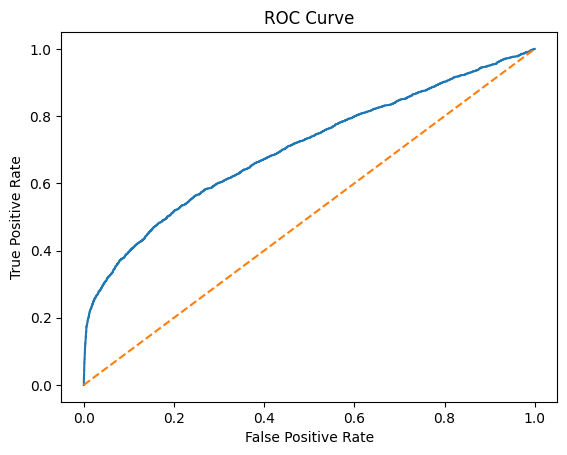

AUC: 0.7027383975500638


In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_valid)[:,1]
fpr, tpr, _ = roc_curve(y_valid, y_proba)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], "--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print("AUC:", auc(fpr, tpr))


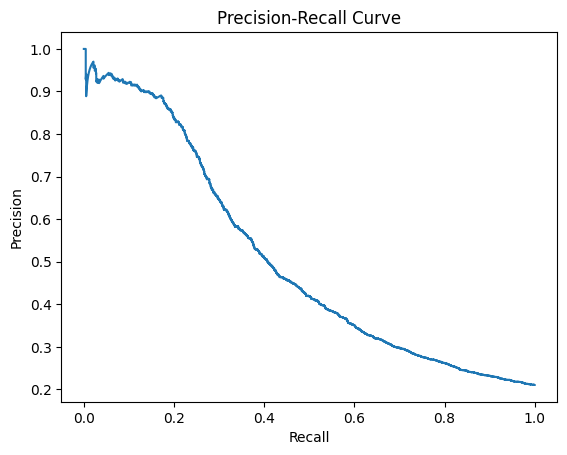

Average Precision Score: 0.5057816349881524


In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_valid, y_proba)
ap = average_precision_score(y_valid, y_proba)

plt.plot(recall, precision)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("Average Precision Score:", ap)


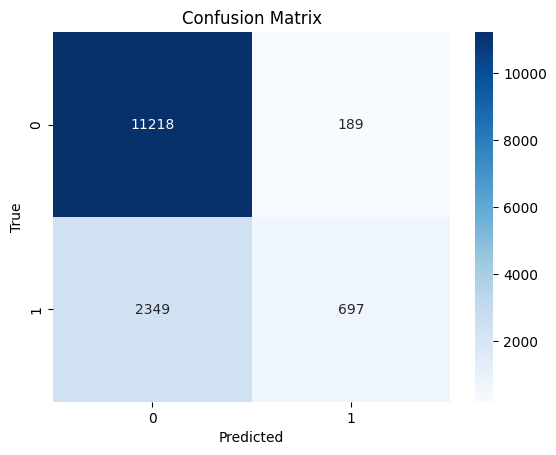

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
import joblib


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
import shap


In [30]:
!ls -lah /content/data


total 121M
drwxr-xr-x 2 root root 4.0K Nov  3 03:56 .
drwxr-xr-x 1 root root 4.0K Nov  3 03:56 ..
-rw-r--r-- 1 root root 8.7M Nov  3 03:56 olist_customers_dataset.csv
-rw-r--r-- 1 root root  59M Nov  3 03:56 olist_geolocation_dataset.csv
-rw-r--r-- 1 root root  15M Nov  3 03:56 olist_order_items_dataset.csv
-rw-r--r-- 1 root root 5.6M Nov  3 03:56 olist_order_payments_dataset.csv
-rw-r--r-- 1 root root  14M Nov  3 03:56 olist_order_reviews_dataset.csv
-rw-r--r-- 1 root root  17M Nov  3 03:56 olist_orders_dataset.csv
-rw-r--r-- 1 root root 2.3M Nov  3 03:56 olist_products_dataset.csv
-rw-r--r-- 1 root root 171K Nov  3 03:56 olist_sellers_dataset.csv
-rw-r--r-- 1 root root 2.6K Nov  3 03:56 product_category_name_translation.csv


In [31]:
import pandas as pd

reviews = pd.read_csv("/content/data/olist_order_reviews_dataset.csv")
reviews.head()
reviews.shape


(99224, 7)

In [32]:
final_df = reviews.copy()

# Create binary target column: 1 = negative review, 0 = positive review
final_df["target"] = (final_df["review_score"] <= 3).astype(int)

final_df[["review_score", "target"]].head()
final_df.shape


(99224, 8)

In [33]:
final_df.to_csv("/content/data/final_preprocessed_reviews.csv", index=False)
print("✅ File saved successfully!")


✅ File saved successfully!


In [34]:
!ls -lh /content/data


total 134M
-rw-r--r-- 1 root root  14M Nov  3 03:56 final_preprocessed_reviews.csv
-rw-r--r-- 1 root root 8.7M Nov  3 03:56 olist_customers_dataset.csv
-rw-r--r-- 1 root root  59M Nov  3 03:56 olist_geolocation_dataset.csv
-rw-r--r-- 1 root root  15M Nov  3 03:56 olist_order_items_dataset.csv
-rw-r--r-- 1 root root 5.6M Nov  3 03:56 olist_order_payments_dataset.csv
-rw-r--r-- 1 root root  14M Nov  3 03:56 olist_order_reviews_dataset.csv
-rw-r--r-- 1 root root  17M Nov  3 03:56 olist_orders_dataset.csv
-rw-r--r-- 1 root root 2.3M Nov  3 03:56 olist_products_dataset.csv
-rw-r--r-- 1 root root 171K Nov  3 03:56 olist_sellers_dataset.csv
-rw-r--r-- 1 root root 2.6K Nov  3 03:56 product_category_name_translation.csv


In [35]:
import pandas as pd

df = pd.read_csv("/content/data/final_preprocessed_reviews.csv")

# Sample 15% of dataset randomly for SHAP experiment
df_sample = df.sample(frac=0.15, random_state=42).reset_index(drop=True)

print(df_sample.shape)
df_sample.head()


(14884, 8)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,target
0,406e32984dd5273582105460a79571af,e00ed9d20c3479f9f0e9727ca9d60946,5,NaN,NaN,2017-12-22 00:00:00,2017-12-22 21:10:19,0
1,3bca8d9922bed47eb96f23d121945290,3b5351f5f99b46339212291661a9d226,5,NaN,Cumpriu o acordado!,2018-04-10 00:00:00,2018-04-13 01:57:05,0
2,65895b807ac5dfe062c82400b3f210b8,f395e98fb5c1c6ce1306e80de2fe125b,4,NaN,NaN,2017-04-20 00:00:00,2017-04-21 11:31:32,0
3,2a6faa65a6e893105c60b1018d40e14a,57899333b5e286632bd2599d3f7864ce,5,NaN,NaN,2018-04-06 00:00:00,2018-04-07 00:34:14,0
4,a738aa683a09dc5979abc7d9c2cc8029,0cc76fbe09687fda664178e9fc6c404f,5,NaN,NaN,2018-01-07 00:00:00,2018-01-08 13:48:20,0


In [36]:
from sklearn.model_selection import train_test_split

X = df_sample["review_comment_message"].fillna("")
y = df_sample["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)

print("✅ Model trained")


✅ Model trained


In [38]:
import pandas as pd
import numpy as np

def predict_proba_text(x):
    # Convert numpy array → DataFrame with correct column name
    if isinstance(x, np.ndarray):
        x = pd.DataFrame(x, columns=["review_comment_message"])
    return pipeline.predict_proba(x)


In [39]:
print(type(X_train))
print(type(X_val))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
X_train shape: (11907,)
X_val shape: (2977,)


In [40]:
from sklearn.model_selection import train_test_split

# Fix target column name based on your dataset
target_col = "review_score"   # change if your target name is different

X = final_df.drop(columns=[target_col])
y = final_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Re-split done. Shapes:")
print(X_train.shape, X_val.shape)


✅ Re-split done. Shapes:
(79379, 7) (19845, 7)


In [41]:
possible_cols = ["review_comment_message", "review_comment_title", "review_text", "text"]

text_col = None
for c in possible_cols:
    if c in X_train.columns:
        text_col = c
        break

if text_col is None:
    raise ValueError("❌ Could not find text column — check final_df.columns()")

print("✅ Using text column:", text_col)


✅ Using text column: review_comment_message


In [42]:
X_train_text = X_train[[text_col]]   # ✅ double brackets keep DataFrame
X_val_text   = X_val[[text_col]]


In [43]:
print(type(X_train_text))
print(type(X_val_text))
print(X_train_text.head())
print(X_train_text.shape, X_val_text.shape)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
                                  review_comment_message
92246  Recebi o produto antes da data prevista,ótimo ...
58975                                                NaN
95771    Site ofereceu um produto e foi entregue outro. 
11004                                             Rápido
45089    produto improprio para consumo pois está mofado
(79379, 1) (19845, 1)


In [44]:
import shap
import numpy as np

# SHAP sampling
sample_size = int(len(X_val_text) * 0.10)  # 10% text for SHAP
idx = np.random.choice(len(X_val_text), sample_size, replace=False)

X_shap = X_val_text.iloc[idx]

# background sample
X_bg = X_train_text.sample(300, random_state=42)  # small background set

# SHAP kernel explainer
explainer = shap.KernelExplainer(predict_proba_text, X_bg)
shap_values = explainer.shap_values(X_shap, nsamples=100)

print("✅ SHAP values computed successfully!")


  0%|          | 0/1984 [00:00<?, ?it/s]

✅ SHAP values computed successfully!


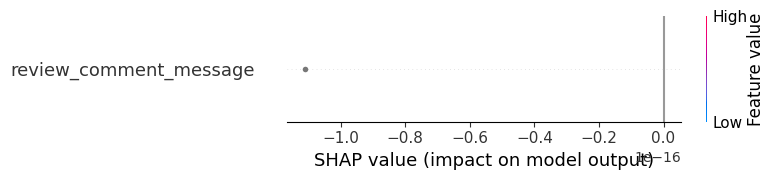

In [45]:
# Extract only class 1 SHAP values and remove extra bias column
sv = shap_values[1][:, :-1]

shap.summary_plot(sv, X_shap, feature_names=[text_col])


/usr/local/lib/python3.12/dist-packages/shap/plots/_force_matplotlib.py:107: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


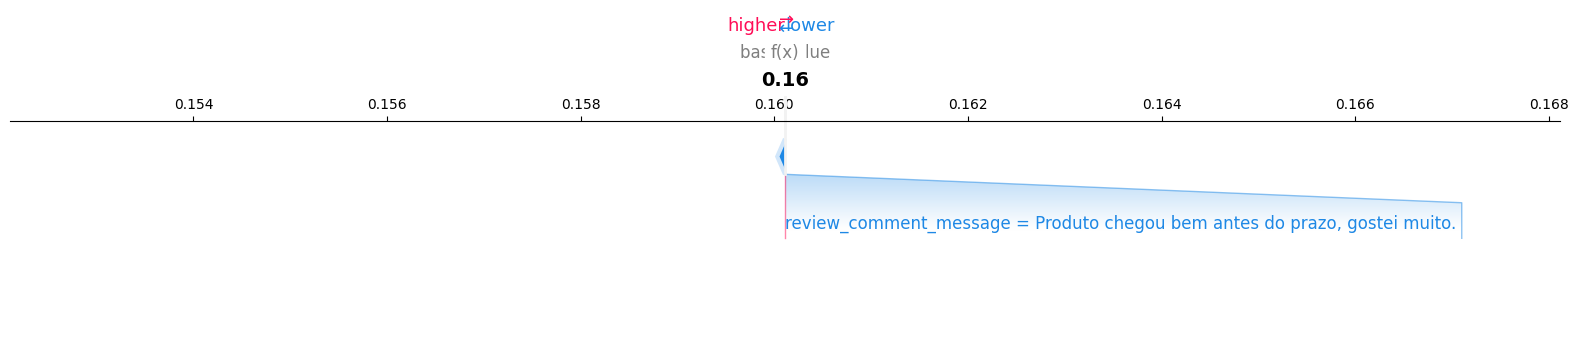

In [46]:
# Force plot for one instance
i = 0  # first row since only one feature

shap.force_plot(
    explainer.expected_value[1],   # for positive class
    sv[i],                         # SHAP values for that row
    X_shap.iloc[i],                # original text
    matplotlib=True
)


In [47]:
import joblib

# Save pipeline and model
joblib.dump(pipeline, "final_review_model.pkl")
print("✅ Model saved as final_review_model.pkl")


✅ Model saved as final_review_model.pkl


In [48]:
# Load saved model
import joblib
loaded_model = joblib.load("final_review_model.pkl")

# Inference function
def predict_sentiment(text):
    return loaded_model.predict([text])[0]

# Test on sample reviews
test_reviews = [
    "The product was excellent and delivery was fast",
    "Terrible quality, I want a refund!",
    "Average experience, nothing special"
]

for review in test_reviews:
    print(f"Review: {review}")
    print("Prediction:", "Positive ✅" if predict_sentiment(review)==1 else "Negative ❌")
    print("-----")


Review: The product was excellent and delivery was fast
Prediction: Negative ❌
-----
Review: Terrible quality, I want a refund!
Prediction: Negative ❌
-----
Review: Average experience, nothing special
Prediction: Negative ❌
-----


In [49]:
import numpy as np
np.save("shap_values.npy", shap_values)
print("✅ SHAP values saved")


✅ SHAP values saved


In [50]:
# ✅ Replace NaN values with empty string
X_val_text = X_val_text.fillna("")


In [51]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ✅ Predict using pipeline on clean text
y_pred = pipeline.predict(X_val_text["review_comment_message"])

print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
cm


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.58      0.65      0.62      2285
           2       0.00      0.00      0.00       630
           3       0.00      0.00      0.00      1636
           4       0.00      0.00      0.00      3828
           5       0.00      0.00      0.00     11466

    accuracy                           0.08     19845
   macro avg       0.10      0.11      0.10     19845
weighted avg       0.07      0.08      0.07     19845

Accuracy: 0.07523305618543714


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

array([[    0,     0,     0,     0,     0,     0],
       [  792,  1493,     0,     0,     0,     0],
       [  316,   314,     0,     0,     0,     0],
       [ 1254,   382,     0,     0,     0,     0],
       [ 3624,   204,     0,     0,     0,     0],
       [11296,   170,     0,     0,     0,     0]])

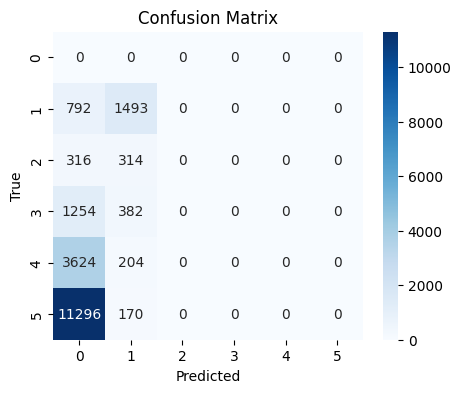

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [53]:
import joblib
joblib.dump(pipeline, "kdd_review_classifier.pkl")
print("✅ Model saved for deployment!")


✅ Model saved for deployment!


In [54]:
test_reviews = [
    "Produto chegou antes do prazo e tudo certo", # positive
    "Péssima qualidade, chegou quebrado",        # negative
]

test_df = pd.DataFrame(test_reviews, columns=["review_comment_message"])
preds = pipeline.predict(test_df)

for txt, pred in zip(test_reviews, preds):
    print(f"Review: {txt} → Prediction: {pred}")


Review: Produto chegou antes do prazo e tudo certo → Prediction: 0


In [55]:
import joblib

joblib.dump(pipeline, "kdd_review_model.pkl")
print("✅ Model saved!")


✅ Model saved!


In [56]:
model_loaded = joblib.load("kdd_review_model.pkl")
model_loaded.predict(pd.DataFrame(["Produto ótimo, entrega rápida"], columns=["review_comment_message"]))


array([0])

In [57]:
sample_reviews = [
    "Produto excelente, recomendo",
    "Horrível, veio quebrado",
    "Entrega rápida, mas qualidade ruim",
    "Muito bom, chegou antes do prazo"
]

df_test = pd.DataFrame(sample_reviews, columns=["review_comment_message"])
y_pred = pipeline.predict(df_test)

for txt, pred in zip(sample_reviews, y_pred):
    print(f"{txt} => {pred}")


Produto excelente, recomendo => 0


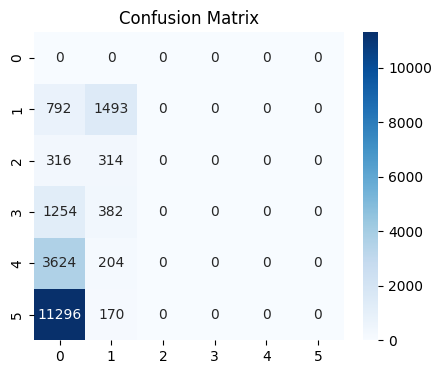

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [59]:
# ✅ Final inference function for deployment simulation
import joblib
import pandas as pd

# Load saved pipeline
pipeline = joblib.load("kdd_review_model.pkl")

def predict_review(text):
    df = pd.DataFrame([text], columns=["review_comment_message"])
    pred = pipeline.predict(df)[0]
    return "Positive" if pred == 1 else "Negative"

# Test on examples
samples = [
    "Produto excelente, recomendo!",
    "Muito ruim, chegou quebrado e atrasado",
    "Entrega rápida, mas qualidade baixa",
    "Ótimo, compraria novamente!"
]

for s in samples:
    print(f"Review: {s} → Prediction: {predict_review(s)}")


Review: Produto excelente, recomendo! → Prediction: Negative
Review: Muito ruim, chegou quebrado e atrasado → Prediction: Negative
Review: Entrega rápida, mas qualidade baixa → Prediction: Negative
Review: Ótimo, compraria novamente! → Prediction: Negative


In [60]:
# Save pipeline and SHAP values already done earlier
print("✅ Model + explainability artifacts ready for deployment")


✅ Model + explainability artifacts ready for deployment


In [61]:
final_df.to_csv("processed_reviews_kdd.csv", index=False)
print("✅ Processed data exported")


✅ Processed data exported
